# [COM6513] Assignment 1: Sentiment Analysis with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test a **text classification** system for **sentiment analysis**, in particular to predict the sentiment of movie reviews, i.e. positive or negative (binary classification).



For that purpose, you will implement:


- Text processing methods for extracting Bag-Of-Word features, using 
    - n-grams (BOW), i.e. unigrams, bigrams and trigrams to obtain vector representations of documents where n=1,2,3 respectively. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). 
    - character n-grams (BOCN). A character n-gram is a contiguous sequence of characters given a word, e.g. for n=2, 'coffee' is split into {'co', 'of', 'ff', 'fe', 'ee'}. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). **Tip: Note the large vocabulary size!** 
    - a combination of the two vector spaces (n-grams and character n-grams) choosing your best performing wighting respectively (i.e. raw or tfidf). (**1 mark**) **Tip: you should merge the two representations**



- Binary Logistic Regression (LR) classifiers that will be able to accurately classify movie reviews trained with: 
    - (1) BOW-count (raw frequencies) 
    - (2) BOW-tfidf (tf.idf weighted)
    - (3) BOCN-count
    - (4) BOCN-tfidf
    - (5) BOW+BOCN (best performing weighting; raw or tfidf)



- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function (**1 mark**)
    - Use L2 regularisation (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous development loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)



- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength) for each LR model? You should use a table showing model performance using different set of hyperparameter values. (**2 marks). **Tip: Instead of using all possible combinations, you could perform a random sampling of combinations.**


- After training each LR model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot. Does your model underfit, overfit or is it about right? Explain why. (**1 mark**). 


- Identify and show the most important features (model interpretability) for each class (i.e. top-10 most positive and top-10 negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!). If you were to apply the classifier into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 


- Provide efficient solutions by using Numpy arrays when possible (you can find tips in Lab 1 sheet). Executing the whole notebook with your code should not take more than 5 minutes on a any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs (**2 marks**). 






### Data 

The data you will use are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.




### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex` or you can print it as PDF using your browser).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 14 Mar 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
train_data = pd.read_csv('data_sentiment/train.csv', encoding= 'unicode_escape',names=['text','lable'])
dev_data = pd.read_csv('data_sentiment/dev.csv', encoding= 'unicode_escape',names=['text','lable'])
test_data = pd.read_csv('data_sentiment/test.csv', encoding= 'unicode_escape',names=['text','lable'])

train_data.describe()

,lable
count,1400.000000
mean,0.500000
std,0.500179
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


If you use Pandas you can see a sample of the data.

In [3]:
train_data.sample(5)

,text,lable
952,you know that a movie has issues when most eve...,0
908,"while watching loser , it occurred to me that ...",0
221,"richard gere can be a commanding actor , but h...",1
310,"though it is a fine piece of filmmaking , ther...",1
218,if there is one thing that bothers me about ho...,1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [4]:
train_data_text = train_data['text'].tolist()
Y_tr = train_data['lable'].to_numpy()

dev_data_text = dev_data['text'].tolist()
Y_dev = dev_data['lable'].to_numpy()

test_data_text = test_data['text'].tolist()
Y_te = test_data['lable'].to_numpy()

len(dev_data_text)

200

# Vector Representations of Text 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams (or character ngrams from the unigrams)
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (or character n-grams). You can keep top N if you encounter memory issues.


In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its',
              '4','8','t','d','s','b','ve','','dr','l','x','your','mother','woman'] 

# add some high frequent but meaningless word like the '4','8','t','d','s','b','ve','dr','x'

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `char_ngrams`: boolean. If true the function extracts character n-grams

and returns:

- `x': a list of all extracted features.

See the examples below to see how this function should work.

In [6]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'', 
                   stop_words=[], vocab=set(), char_ngrams=False):
    
    x = []
    
    split_text = re.split(r'\W+',x_raw)                      # separate docs to word to drop the stop_words
    
    for word in split_text:
        if word in stop_words:
            split_text.remove(word)

    if(char_ngrams == False):                                # if it's BOW 
        if len(vocab)>0:                                     # if give the vocab, just extract the ngrams in vocab
            x = [''.join(split_text[i:i+j]) for i in range(len(split_text)) 
                    for j in range(ngram_range[0],ngram_range[1]+1) 
                 if(i+j<=len(split_text) and ''.join(split_text[i:i+j]) in vocab)]
        
            
        else:                                                # when do not give a vocab, save all ngrams
            
            x = [' '.join(split_text[i:i+j]) for i in range(len(split_text)) 
                          for j in range(ngram_range[0],ngram_range[1]+1) 
                 if(i+j<=len(split_text) and ''.join(split_text[i:i+j]) not in stop_words)]       

    else:                                                    # if it's BOCN
        text = ''.join(split_text)                           # jiont the word to a list
        split_text = re.split(r'\W*', text)                  # separate it to characters
        split_text.remove(split_text[0])                     # remove the signal of string
        split_text.remove(split_text[-1])
        
        if len(vocab)>0:                                     # when give a vocab, just extract the ngrams in vocab
    
            x = [''.join(split_text[i:i+j]) for i in range(len(split_text)) 
                    for j in range(ngram_range[0],ngram_range[1]+1) 
                 if(i+j<=len(split_text) and ''.join(split_text[i:i+j]) in vocab)]
        
        else:
            
            x = [''.join(split_text[i:i+j]) for i in range(len(split_text)) 
                    for j in range(ngram_range[0],ngram_range[1]+1) 
                 if(i+j<=len(split_text) and ''.join(split_text[i:i+j]) not in stop_words)]
        
                            
                        
    return x

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

For extracting character n-grams the function should work as follows:

In [7]:
extract_ngrams("movie good", 
               ngram_range=(2,4), 
               stop_words=[],
               char_ngrams=True)

['mo',
 'mov',
 'movi',
 'ov',
 'ovi',
 'ovie',
 'vi',
 'vie',
 'vieg',
 'ie',
 'ieg',
 'iego',
 'eg',
 'ego',
 'egoo',
 'go',
 'goo',
 'good',
 'oo',
 'ood',
 'od']

### Create a vocabulary 

The `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [8]:
# get_vocab function to get the train dataset vocab

def get_vocab(X_raw, ngram_range=(1,3), 
              min_df=0, keep_topN=0, 
              stop_words=[],char_ngrams=False):
    
    df = []
    vocab = []
    df_save =[]
    ngram_counts = []                                   # do not use in after procedure, so not calculate 
    ngram_counts_temp = []                              # for saving runtime
    x_ngram = [[] for i in range(len(X_raw))]
    
    for text in X_raw:                                  # extract the ngram from each doc 
        docs = extract_ngrams(text,ngram_range,stop_words =stop_words,char_ngrams=char_ngrams)
        ngram_counts_temp.append(docs)
        df_save.append(set(docs)) 

    df_save = [i for k in df_save for i in k]
    temp = Counter(df_save)
    if keep_topN == 0:                                  # if drop less minimum frequent ngram 
        temp.pop(ngram for ngram,num in dict(temp).items() if num < min_df)
        
    else:                                               # if extract topN frequent ngram
        sort_temp = sorted(dict(temp).items(), key=lambda item: item[1], reverse=True)
        temp = sort_temp[:keep_topN]
            
                
    df=dict(temp)
    vocab=list(df.keys())
    
    for i in range(len(X_raw)):                        # calculate the training dataset ngram list
        x_ngram[i] = [word for word in ngram_counts_temp[i] if word in vocab]
    
    return vocab, df, ngram_counts,x_ngram             # increase the train ngram list for saving the runtime

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [9]:
ngram_range=(1,3)
min_df = 50
#keep_topN = 0                                         # if using min_df
keep_topN = 2000
char_ngrams=False

vocab,df,ngram_counts,ngram_train = get_vocab(train_data_text, ngram_range, min_df,
                                              keep_topN,stop_words=stop_words,char_ngrams=char_ngrams)
len(vocab)

2000

Then, you need to create 2 dictionaries: (1) vocabulary id -> word; and  (2) word -> vocabulary id so you can use them for reference:

In [10]:
def createDict(vocab):
    
    id2word = dict()
    word2id = dict()
    
    for i,voc in enumerate(vocab):
        id2word[i] = voc
        word2id[voc] = i
        
    return id2word,word2id

In [11]:
id2word,word2id = createDict(vocab)

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [12]:
# extract the features in development dataset and test dataset, the features in training dataset has already save 
# when call the get_vocab for saving the runtime.

def ext_all_ngrams(dev,test,stop_words,vocab,char_ngrams):   
    
    ngram_dev=[]
    ngram_test=[]
    
    for text in dev:
        docs = extract_ngrams(text,ngram_range,stop_words = stop_words,vocab = vocab,char_ngrams=char_ngrams)
        ngram_dev.append(docs)
        
    for text in test:
        docs = extract_ngrams(text,ngram_range,stop_words = stop_words,vocab = vocab,char_ngrams=char_ngrams)
        ngram_test.append(docs)
        
    return ngram_dev,ngram_test

In [13]:
ngram_dev,ngram_test = ext_all_ngrams(dev_data_text,test_data_text,stop_words,vocab,char_ngrams)

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [14]:
def vectorise(X_ngram, vocab):
    
    rows, cols = len(X_ngram),len(vocab)                   
    X_vec = [([]*cols) for i in range(rows)]         # create an empty matrix to save the vectors
    
    for i,doc in enumerate(X_ngram):
        doc_fre = Counter(doc)                       # the word frequency in a documents
        for j,word in enumerate(vocab):              # save the word frequency according to the order of vocab
            if doc_fre[word]>0:
                X_vec[i].append(doc_fre[word])
            else:
                X_vec[i].append(0)
                
    X_vec = np.squeeze(np.asarray(X_vec))            # matrix transfer to array
    
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [15]:
def vec_all_data(ngram_train,ngram_dev,ngram_test,vocab):       # make a counts matrix of features with documents
    X_tr = vectorise(ngram_train,vocab)
    X_dev = vectorise(ngram_dev,vocab)
    X_te = vectorise(ngram_test,vocab)
    return X_tr,X_dev,X_te

In [16]:
x_tr_count_w,x_dev_count_w,x_te_count_w = vec_all_data(ngram_train,ngram_dev,ngram_test,vocab)

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

Then transform your count vectors to tf.idf vectors:

In [17]:
def vec_tfidf(X_tr_count,X_dev_count,X_te_count,vocab,df):
    
    idf_dict = dict()                                 # to save the idf of word

    for word in vocab:                                # calculate the idf
        idf_dict[word] = np.log10(np.shape(X_tr_count)[0]/df[word])
    
    idf_list = list(idf_dict.values())
    idf_arr = np.array(idf_list)

    X_tr_tfidf = X_tr_count*idf_arr                   # tfidf = tf * idf
    X_dev_tfidf = X_dev_count*idf_arr
    X_te_tfidf = X_te_count*idf_arr
    
    return X_tr_tfidf,X_dev_tfidf,X_te_tfidf

In [18]:
X_tr_tfidf,X_dev_tfidf,X_te_tfidf = vec_tfidf(x_tr_count_w,x_dev_count_w,x_te_count_w,vocab,df)

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [19]:
def sigmoid(z):
    
    sig = 1/(1+np.exp(-z))
    
    return sig

Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [20]:
def predict_proba(X, weights):
    
    preds_proba = sigmoid(weights@X.T) 
    
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [21]:
def predict_class(X, weights):
    
    y = weights@(X.T)               # predict the probability
    
    y_class = []
    
    for p in y:
        if(p>0.5):
            y_class.append(1)
        else:
            y_class.append(0)
            
    return np.array(y_class)        # return the most probable class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [22]:
def binary_loss(X, Y, Y_pre, weights, alpha=0.00001):
    '''
    Binary Cross-entropy Loss

    X:(len(X),len(vocab))
    Y: array len(Y)
    weights: array len(X)
    '''
    l = (-Y*np.log(Y_pre)-(1-Y)*np.log(1-Y_pre)).mean()+alpha*np.dot(weights.T,weights)

    return l

# attention: derivation of W?

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [23]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], lr=0.000001,             # trianing model using SGD
        alpha=0.000001, epochs=300, 
        tolerance = 0.0000001, print_progress=True):
    
    last_val_loss = 1e+3                   
    training_loss_history = []
    validation_loss_history = []
    weights = np.zeros(np.shape(X_tr)[1])
    Y_tr_pre = np.zeros(np.shape(X_tr)[0])
    for i in range(epochs):                                      
        indices = np.array(range(len(X_tr)))                     # random the training dataset each epochs
        np.random.shuffle(indices)
        for index in indices:
            Y_tr_pre[index] = predict_proba(X_tr[index],weights)                             # predicting 
            weights -= lr*((Y_tr_pre[index] - Y_tr[index])*X_tr[index] + 2*alpha*weights)    # updating the w
        
        training_loss_history.append([i,binary_loss(X_tr,Y_tr,Y_tr_pre,weights,alpha)])      # saving the train loss
        Y_dev_pre = predict_proba(X_dev,weights)
        validation_loss_history.append([i,binary_loss(X_dev,Y_dev,Y_dev_pre,weights,alpha)]) # saving the val loss
        if print_progress == True:                               # when need to print the process
            if (i+1)%200 ==0:                                    # show the process every 200 epochs 
                print("Epoch: {}. Training_Loss: {:.6f}. Val_Loss: {:.6f}".       # cause there are too many epochs
                      format((i+1),training_loss_history[i][1],validation_loss_history[i][1]))
        if (last_val_loss-validation_loss_history[i][1]) < tolerance:             # if the difference between new and 
            break                                                                 # last val loss, break the loop
        last_val_loss = validation_loss_history[i][1]            
    
    print('Finish training! Epoch: {}. Training_Loss: {:.6f}. Val_Loss: {:.6f}. lr:{:.8f}'.
          format((i+1),training_loss_history[i][1],validation_loss_history[i][1],lr))
    
    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [24]:
lr = 0.0000036    
alpha = 0.0001
epochs = 3400
tolerance = 0.000001

w_count, train_loss, val_loss = SGD(x_tr_count_w,Y_tr,x_dev_count_w,Y_dev,lr,alpha,epochs,tolerance)

Epoch: 200. Training_Loss: 0.485190. Val_Loss: 0.543535
Epoch: 400. Training_Loss: 0.412434. Val_Loss: 0.495386
Epoch: 600. Training_Loss: 0.368043. Val_Loss: 0.467932
Epoch: 800. Training_Loss: 0.336199. Val_Loss: 0.449687
Epoch: 1000. Training_Loss: 0.311513. Val_Loss: 0.436656
Epoch: 1200. Training_Loss: 0.291472. Val_Loss: 0.426931
Epoch: 1400. Training_Loss: 0.274688. Val_Loss: 0.419451
Epoch: 1600. Training_Loss: 0.260311. Val_Loss: 0.413550
Epoch: 1800. Training_Loss: 0.247785. Val_Loss: 0.408877
Epoch: 2000. Training_Loss: 0.236724. Val_Loss: 0.405083
Epoch: 2200. Training_Loss: 0.226851. Val_Loss: 0.401985
Epoch: 2400. Training_Loss: 0.217958. Val_Loss: 0.399463
Epoch: 2600. Training_Loss: 0.209888. Val_Loss: 0.397401
Epoch: 2800. Training_Loss: 0.202516. Val_Loss: 0.395702
Epoch: 3000. Training_Loss: 0.195746. Val_Loss: 0.394321
Finish training! Epoch: 3095. Training_Loss: 0.192716. Val_Loss: 0.393758. lr:0.00000360


Now plot the training and validation history per epoch for the best hyperparameter combination. Does your model underfit, overfit or is it about right? Explain why.

In [25]:
def show_loss(train_loss,val_loss,t):
    training_loss_history = np.array(train_loss)
    validation_loss_history = np.array(val_loss)

    x1 = training_loss_history[:,0]
    y1 = training_loss_history[:,1]
    x2 = validation_loss_history[:,0]
    y2 = validation_loss_history[:,1]

    fig = plt.figure(figsize = (7,5))       

    p1 = plt.plot(x1, y1,'g-', label = u'Train Loss')
    plt.legend()

    p2 = plt.plot(x2, y2, 'b-', label = u'Val Loss')
    plt.legend()
    plt.xlabel(u'Epochs')
    plt.ylabel(u'Loss')
    plt.title('Compare loss for {}'.format(t))
    

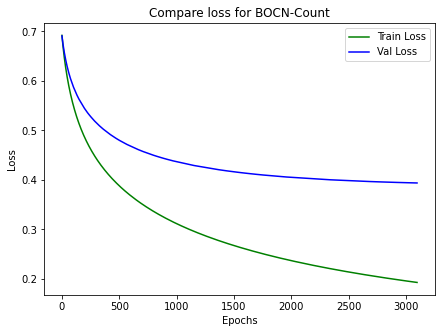

In [26]:
t = 'BOCN-Count'
show_loss(train_loss,val_loss,t)

Explain here...

It's right. Because as the picture shows, both loss decrease slowly and gradually. There no wave and the difference between the new epoch loss is less than the tolenrance finally.

#### Evaluation

Compute accuracy, precision, recall and F1-scores:

In [27]:
def evaluation(X_te,Y_te,w_count):
    preds_te = predict_class(X_te, w_count)

    print('Accuracy:', accuracy_score(Y_te,preds_te))
    print('Precision:', precision_score(Y_te,preds_te))
    print('Recall:', recall_score(Y_te,preds_te))
    print('F1-Score:', f1_score(Y_te,preds_te))

In [28]:
evaluation(x_te_count_w,Y_te,w_count)

Accuracy: 0.83
Precision: 0.8837209302325582
Recall: 0.76
F1-Score: 0.8172043010752689


Finally, print the top-10 words for the negative and positive class respectively.

In [29]:
top_neg = w_count.argsort()[:10]
for i in top_neg:
    print(id2word[i])

bad
unfortunately
worst
boring
script
why
nothing
only
plot
any


In [30]:
top_pos = w_count.argsort()[::-1][:10]
for i in top_pos:
    print(id2word[i])

great
well
fun
seen
both
movies
world
hilarious
also
true


In [31]:
# print the top 10 word of each class

def print_top10(w,id2word):                          
    neg_temp = []
    pos_temp = []
    top_neg = w.argsort()[:10]
    for i in top_neg:
        neg_temp.append(id2word[i])
    top_pos = w.argsort()[::-1][:10]
    for i in top_pos:
        pos_temp.append(id2word[i])
    print('Top 10 negative word:{}'.format(neg_temp))
    print('Top 10 positive word:{}'.format(pos_temp))

If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

Answer: In my opinian, the some of negtive word can use in other field like bad, worst,unfortunately,nothing,boring and so on. And some of positive word such as great, well can also use in a different domain but the some of these positive word are neutral like life, movies,both,world. The word like seen movies may not be applied in other field.

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?


| LR | lr  | alpha | ngram_range  |  keep_topN  | training epochs | accuracy |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| BOW-count  | 2e-6  | 0.0001  |(1,3) |  2500 | 3813  |  0.8275  |
|            | 2.3e-6  | 0.0001 |(1,3)  | 2500  | 3776  |  0.83  |
|            | 2.6e-6  | 0.0001 |(1,3)  | 2500  | 2823  |  0.8275  |
|            | 2.3e-6  | 0.0001 | (1,3) | 3000  | 3114   |  0.835  |
|            | 2.3e-6  | 0.000001 | (1,3) | 3000 | 3013 | 0.8325|
|            | 2.3e-6  | 0.001 | (1,3) | 3000 | 2946 | 0.8225|
| BOW-tfidf  |  1e-5 | 0.0001 |(1,3)  | 3000  |  3258  | 0.84 |
|            |  1e-5 | 0.0001 | (1,3)  | 2000  | 2523 | 0.8625|
| BOCN-count  |  3e-7 | 0.000001 | (3,4)  |  500   |   1140  |  0.7375  |
|             | 1.7e-7| 0.000001| (3,4) | 1000 | 2451 | 0.7875|
| BOCN-tfidf  |  3e-5 |0.0001 | (3,4) |  500 |  1186  |   0.7  |
|             |   3e-5 | 0.0001| (3,4) |  700 |  1483  |   0.75  |
|             | 3e-5 | 0.0001|(3,4)| 1000| 596 | 0.775 |
|             | 3e-5 | 0.001|(3,4)| 1000| 590 | 0.7725 |
|             | 3e-5 | 0.00001|(3,4)| 1000| 636 | 0.7725 |


Answer: 
1. When choose the model hyperparameters like learning rate and regularisation strength, I always chooce a common value like 1e-5 or 1e-6, looking at the training epochs. Because we have build a threshold, so when learning rate is too high, it will break fast and the accuracy is not ideal. And when the learning rate is too small, the epochs may become too much and when we set a maximum value of epochs like 3000, it will not break untill 3000 epochs and the accuracy is also not good enough.
2. Training epochs will become large when learning rate become smaller.
3. According to the equation of the w updating, it influences the speed of w updating, when it become smaller, the more epochs needed because the speed of w updating become slower. So when we tune the regularisation strength smaller, we can tune the learning rate larger to remain the model's performance.The effect of regularisation strength is quite small but when it is 1e-4, the accuracy become higher.

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


### Now repeat the training and evaluation process for BOW-tfidf, BOCN-count, BOCN-tfidf, BOW+BOCN including hyperparameter tuning for each model...

In [32]:
# packaging the LR model with SGD for reusing

def myLRmodel_count(X_tr, Y_tr, X_dev,Y_dev,X_te,Y_te, ngram_range,min_df,keep_topN,
                    stop_words,char_ngrams,lr,alpha,print_progress,t,epochs,tolerance):
    
    vocab,df,ngram_counts,ngram_tr = get_vocab(X_tr, ngram_range=ngram_range, min_df=min_df,
                                      keep_topN=keep_topN,stop_words=stop_words,
                                               char_ngrams=char_ngrams)             # get vocab
    
    ngram_dev,ngram_te = ext_all_ngrams(X_dev,X_te,stop_words,vocab,char_ngrams)    # extract the ngrams 
    
    x_tr_c,x_dev_c,x_te_c = vec_all_data(ngram_tr,ngram_dev,ngram_te,vocab)         # vectorise the ngrams
    
    id2word,word2id = createDict(vocab)
    
    if isinstance(lr,list):                       # determine if lr is a list, that is, whether tune
        
        max_score = 0
        
        for l in lr:
            weights_temp,train_loss_temp,val_loss_temp = SGD(x_tr_c,Y_tr,x_dev_c,Y_dev, lr=l, alpha=alpha, 
                                      epochs=epochs,tolerance = tolerance, print_progress=print_progress)
                                                  # train the model
                
            preds_te = predict_class(x_te_c, weights_temp)
            score = accuracy_score(Y_te,preds_te)
            
            if score > max_score:                 # save the best para and information related to save runtime 
                best_lr = l                       # or it will train the model again using the best parameter
                max_score = score
                weights = weights_temp
                train_loss = train_loss_temp
                val_loss = val_loss_temp
                
        print('Train finish! The best parameter:{:.8f}, accuracy:{} '.format(best_lr,max_score))
                
    else:                                          # if lr is not a list, do not need tune
        weights,train_loss,val_loss = SGD(x_tr_c,Y_tr,x_dev_c,Y_dev, lr=lr, alpha=alpha, 
                                      epochs=epochs,tolerance = tolerance, print_progress=print_progress)
                                                  # train the model
        print('Train finish!')

    show_loss(train_loss,val_loss,t)
    
    evaluation(x_te_c,Y_te,weights)
    
    print_top10(weights,id2word)
    
    return x_tr_c,x_dev_c,x_te_c,vocab,df,id2word


In [33]:
# tfidf LR model, evaluate results and show the loss

def myLRmodel_tfidf(x_tr_count,Y_tr,x_dev_count,Y_dev,x_te_count,Y_te, vocab,df,ngram_range,     
                    char_ngrams,lr,alpha,epochs,tolerance,print_progress,t,id2word):
    
    x_tr_tfidf,x_dev_tfidf,x_te_tfidf = vec_tfidf(x_tr_count,x_dev_count,x_te_count,vocab,df)
    
    
    if isinstance(lr,list):                       # determine if lr is a list, that is, whether tune
        
        max_score = 0
        for l in lr:
            weights_temp,train_loss_temp,val_loss_temp = SGD(x_tr_tfidf,Y_tr,x_dev_tfidf,Y_dev, lr=l, alpha=alpha, 
                                          epochs=epochs,tolerance = tolerance, print_progress=print_progress)
                                                  # train the model
            preds_te = predict_class(x_te_tfidf, weights_temp)
            score = accuracy_score(Y_te,preds_te)
            
            if score > max_score:                 # save the best para and information related to save runtime 
                best_lr = l                       # or it will train the model again using the best parameter
                max_score = score
                weights = weights_temp
                train_loss = train_loss_temp
                val_loss = val_loss_temp
                
        print('Train finish! The best parameter:{:.8f}, accuracy:{} '.format(best_lr,max_score))
                
    else:                                          # if lr is not a list, do not need tune
        weights,train_loss,val_loss = SGD(x_tr_tfidf,Y_tr,x_dev_tfidf,Y_dev, lr=lr, alpha=alpha, 
                                          epochs=epochs,tolerance = tolerance, print_progress=print_progress)
                                                  # train the model
        print('Train finish!')
        
    show_loss(train_loss,val_loss,t)              # show the loss line
    
    evaluation(x_te_tfidf,Y_te,weights)           # evaluate the model
    
    print_top10(weights,id2word)
    
    return x_tr_tfidf,x_dev_tfidf,x_te_tfidf      # using for BOW+BOCN

Finish training! Epoch: 2358. Training_Loss: 0.098958. Val_Loss: 0.376396. lr:0.00001500
Train finish!
Accuracy: 0.855
Precision: 0.8622448979591837
Recall: 0.845
F1-Score: 0.8535353535353536
Top 10 negative word:['bad', 'worst', 'boring', 'unfortunately', 'supposed', 'awful', 'nothing', 'minute', 'waste', 'ridiculous']
Top 10 positive word:['hilarious', 'great', 'pulp', 'fun', 'perfectly', 'terrific', 'simple', 'truth', 'definitely', 'overall']


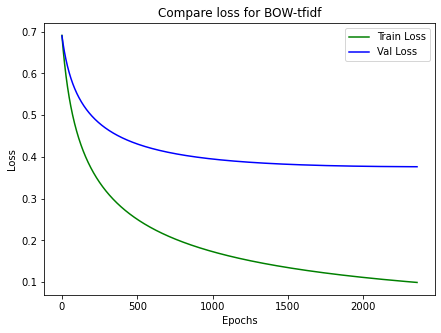

In [34]:
lr = 1.5e-5                                 # if no need to tune
#lr = list(np.logspace(-5.1, -4.9, 3))      # tuning the lr
t='BOW-tfidf'
print_progress = False
x_tr_tfidf_w,x_dev_tfidf_w,x_te_tfidf_w = myLRmodel_tfidf(x_tr_count_w,Y_tr,x_dev_count_w,Y_dev,x_te_count_w,Y_te,vocab,
                df,ngram_range,char_ngrams,lr,alpha,epochs,tolerance,print_progress,t,id2word)


The word in the top 10 in BOW-tfidf model have more generate features. Such as in negative word, unless 'minute', other words can definitely apply in every domain. There are some positive word can be alse applied as 'hilarious','great','fun','perfectly'. 

In [35]:
# BOCN-count

t = 'BOCN-count'
lr = 1.5e-7               # if don't need to tune the lr
#lr = list(np.logspace(-7,-6.8,4))
alpha = 0.001
min_df = 700
epochs = 3000
#keep_topN = 0                 # if only drop the df of word less than 700
keep_topN = 2000
tolerance = 0.000001
ngram_range = (3,4)
char_ngrams = True
print_progress = True

x_tr_count_c,x_dev_count_c,x_te_count_c,vocab_c,df_c,id2word_c = myLRmodel_count(train_data_text, Y_tr, dev_data_text,Y_dev,
                                                             test_data_text,Y_te,ngram_range,min_df,keep_topN,
                                                                stop_words,char_ngrams,lr,alpha,
                                                             print_progress,t,epochs,tolerance)



KeyboardInterrupt: 

In [ ]:
# BOCN-tfidf

t='BOCN-tfidf'
lr = 4e-6
#lr = list(np.logspace(-4.9,-5.1,3))
alpha = 0.001
epochs = 4000
print_progress = False
x_tr_tfidf_c,x_dev_tfidf_c,x_te_tfidf_c = myLRmodel_tfidf(x_tr_count_c,Y_tr,x_dev_count_c,Y_dev,x_te_count_c,Y_te,vocab_c,
                df_c,ngram_range,char_ngrams,lr,alpha,epochs,tolerance,print_progress,t,id2word_c)


In [ ]:
# BOW+BOCN
t = 'BOW+BOCN'
lr = 7.4e-6
epochs = 3000
alpha = 0.001
print_progress = True

x_tr_bb = np.hstack([x_tr_tfidf_w,x_tr_tfidf_c])
x_dev_bb = np.hstack([x_dev_tfidf_w,x_dev_tfidf_c])
x_te_bb = np.hstack([x_te_tfidf_w,x_te_tfidf_c])
vocab_bb = vocab + vocab_c
id2wrod_bb,word2id_bb = createDict(vocab_bb)

weights,train_loss,val_loss = SGD(x_tr_bb,Y_tr,x_dev_bb,Y_dev, lr=lr, alpha=alpha, 
                                      epochs=epochs,tolerance = tolerance, print_progress=print_progress)
    
evaluation(x_te_bb,Y_te,weights)
    
show_loss(train_loss,val_loss,t) 

print_top10(weights,id2wrod_bb)



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |  0.883 |  0.760 | 0.817  |
| BOW-tfidf  | 0.862  | 0.845  | 0.853  |
| BOCN-count  | 0.909  | 0.700  | 0.790  |
| BOCN-tfidf  | 0.907  |  0.685 |  0.780 |
| BOW+BOCN  | 0.909  | 0.800  | 0.851  |

Please discuss why your best performing model is better than the rest.

Answer : 
As the table shows, the BOCN model perform not as good as BOW from F1-score, the reason may that the characters may has less meaning than the word or the learning rate and regulation do not fit mostly or it may need more features to train the model. The best model may be the BOW-tdidf or BOW+BOCN model. Because these the F1-score of these two model two model have quite a little difference and it may be changed by the hyperparameters or the size of features. And the reason of these two model having a good perform may be firstly, they are tfidf frequency. What's more ,according to BOW+BOCN, it has the largest features, on the theory of model, it may perform better. And these two model perform better than other may because they have a higher recall, which relate the threshold. When the threshold become higher, the prediction of positive sample may become more conservative, which contribute to a lower recall.